In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import fiona
import sklearn

In [15]:
-1897.7-70.7

-1968.4

In [2]:
#Upload the selection
selection = []

with open('/Users/francesco/Desktop/Thesis/Data/dataset_filtered' + '/selecao.txt', 'r') as f:
    for line in f:
        selection.append(int(line.strip()))

common_years = np.arange(2005,2017,1)

print('The shape of the selection is: ', np.shape(selection))

The shape of the selection is:  (128,)


In [4]:
path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
regions = []
areas = []
lats = []
lons = []


shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])

for feature in shapefile:


    id = feature['properties']['id']
    name=feature['properties']['name']
    area=feature['properties']['area_fra']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']

    #Taking the info
    ids.append(id)
    Names.append(name)
    regions.append(region)
    areas.append(area)
    lats.append(lat)
    lons.append(lon)

#Creating the dataframe
df_region = pd.DataFrame(index=ids)
df_region ['id'] = ids
df_region ['Name'] = Names
df_region ['Region'] = regions
df_region ['Area'] = areas
df_region ['Latitude'] = lats
df_region ['Longitude'] = lons

#Selecting the region and sorting the dataframe
df_region = df_region[df_region['id'].isin(selection)]
df_region = df_region.sort_values(by=['id'])
#drop id column
df_region = df_region.drop(['id'], axis=1)


{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'float:24.15', 'mass_los16': 'float:24.15', 'mass_los17': 'floa

In [5]:
#Loading the dataset
dataset_directory = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/'

# Basal Melting
bm = pd.read_csv(dataset_directory + '/bm.csv', index_col=0)
bm = bm.sort_values(by=['id']) #sorting the glaciers by their index
bm = bm.loc[bm.index.isin(selection)] #selecting the glaciers, according to their index
bm = bm[common_years.astype(str)] #selecting the common years
bm = bm.sort_index() #sorting the glaciers by their index

#Load the calving data
calving = pd.read_csv(dataset_directory+ '/df_calving_from_shp_negative_and_positive.csv', index_col=0)
calving = calving.loc[calving.index.isin(selection)]
calving = calving[common_years.astype(str)]
#sort the calving by its index
calving = calving.sort_index()

#Load the ice concentration data
i_c = pd.read_csv(dataset_directory + '/ice_c_avg_extended_front.csv', index_col=0)
i_c = i_c.loc[i_c.index.isin(selection)]
i_c = i_c[common_years.astype(str)]
i_c = i_c.sort_index()

#Load the ice velocity data
i_v = pd.read_csv(dataset_directory + '/velocity_80_percentile_extended_front_2011_2012_linear_trend.csv', index_col=0)
i_v = i_v.loc[i_v.index.isin(selection)]
i_v = i_v[common_years.astype(str)]
i_v = i_v.sort_index()

#Load the ice thickness data
i_t = pd.read_csv(dataset_directory + '/thickness_avg_extended front.csv', index_col=0)
i_t = i_t.loc[i_t.index.isin(selection)]
i_t = i_t[common_years.astype(str)]
i_t = i_t.sort_index()

index = bm.index

In [6]:
#make a dataset with all the variables
dataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])
dataset.columns.names = ['Variables', 'Years']
dataset.index.names = ['Glaciers']

#i want to split the dataset in two, one with the variables and one with the target. The target is ice calving
dataset_target = dataset['calving']
dataset_variables = dataset.drop(['calving'], axis=1)

In [7]:
#Now i want to split both the dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_variables, dataset_target, test_size=0.3, random_state=42)

In [8]:
X_train.i_v.loc[36]

Years
2005    1153.487939
2006     688.516797
2007    1244.268213
2008    1241.833057
2009    1232.791382
2010    1215.889771
2011    1169.446791
2012    1184.546981
2013    1234.066650
2014    1220.048560
2015    1166.643774
2016    1191.220435
Name: 36.0, dtype: float64

In [9]:
#Scalarization.Should i do it? Probably not, since Random Forest is not very sensitive to the magnitude of the variables

''' 
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
np.shape(X_train_scaled)
'''

' \nfrom sklearn.preprocessing import StandardScaler\nstd_scaler = StandardScaler()\n\nX_train_scaled = std_scaler.fit_transform(X_train)\nnp.shape(X_train_scaled)\n'

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Initialise the model
rf = RandomForestRegressor(random_state=42)

#Set a grid of parameters
param_grid = {
    'n_estimators': [100, 500, 1000, 1500], 
    'max_leaf_nodes': [None, 16, 32, 64], 
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

#Fit the grid to the training data
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)


#Training the model
#rf.fit(X_train, y_train)

{'max_leaf_nodes': None, 'n_estimators': 500}
-3.1129931969608013


In [11]:
beast_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
beast_n_estimators = grid_search.best_params_['n_estimators']

best_rf = RandomForestRegressor(max_leaf_nodes=beast_max_leaf_nodes, n_estimators=beast_n_estimators, random_state=42)

best_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [12]:
predictions = best_rf.predict(X_test)

In [13]:
from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
#Evaluating the model
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


#Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

#Visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#Plotting the predictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#Plotting the residuals
plt.scatter(predictions, y_test-predictions)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

MAE: 4.9132847008547005
MSE: 137.19971786560686
RMSE: 11.713228328074496


type: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Now i want to create a dataset, which contains the predictions, and their respective index, which is the glacier id of the y_test
df_predictions = pd.DataFrame(index=y_test.index, columns= common_years)

i = 0
for id in y_test.index:
    df_predictions.loc[id] = predictions[i]
    i = i + 1
i=0

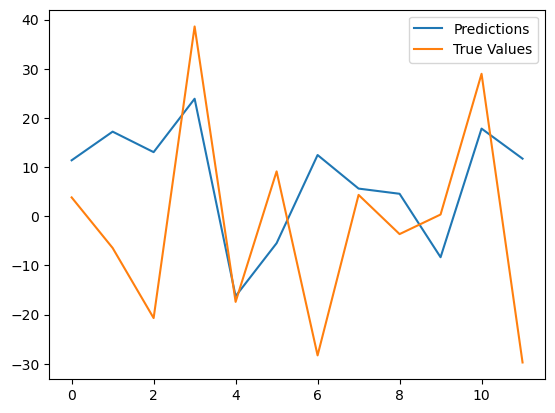

In [ ]:
id = 98


#Plot both the predictions and the y_train.iloc[0].values

plt.plot(df_predictions.loc[id].values)
plt.plot(y_test.loc[id].values)

#Add legend and title
plt.legend(['Predictions', 'True Values'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE: 4.94559829059829
MSE: 138.63969305435896
RMSE: 11.774535789336197


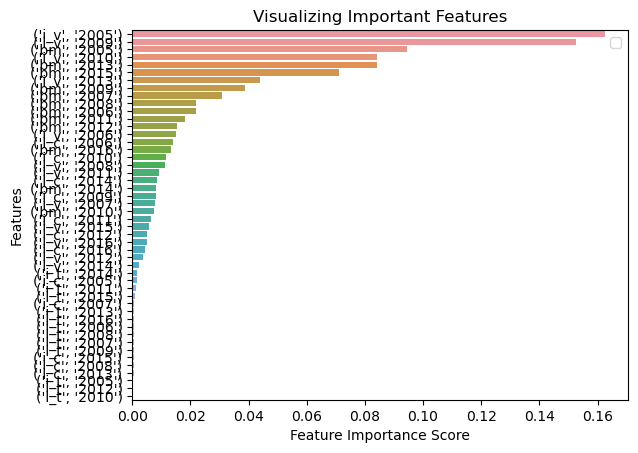

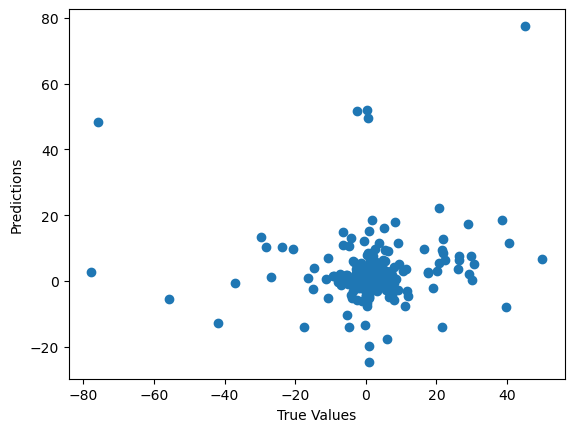

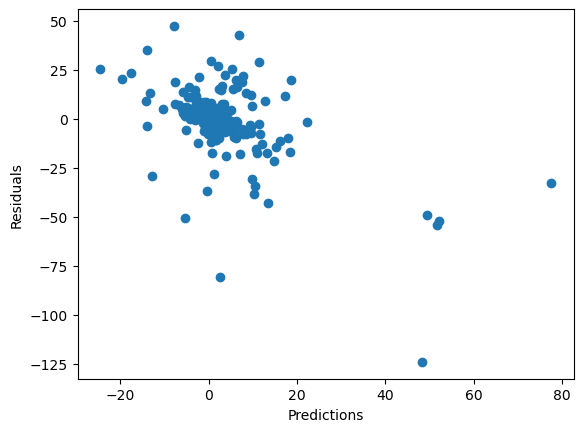

In [ ]:
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

#Evaluating the model
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


#Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

#Visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#Plotting the predictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#Plotting the residuals
plt.scatter(predictions, y_test-predictions)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()



In [ ]:
np.shape(y_test)
np.shape(predictions)

(39, 12)

In [ ]:
np.shape(y_test)

(39, 12)

In [ ]:
y_test

Years,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Glaciers,,,,,,,,,,,,
73.0,-7.02,-11.25,-16.40,6.66,-2.32,1.84,0.48,3.07,2.54,0.50,-5.30,1.16
57.0,26.40,9.53,4.70,8.54,7.30,-55.77,3.33,2.14,3.94,-37.14,-0.57,8.13
33.0,0.36,-1.48,2.82,-3.12,-1.35,0.99,0.67,0.70,0.57,-0.45,0.27,0.33
46.0,0.16,0.69,0.59,-1.43,-4.70,0.82,-2.67,-0.81,-2.80,-5.24,-2.76,-0.03
122.0,0.76,0.84,0.58,1.13,0.16,0.65,0.86,0.59,0.81,-0.02,-1.57,-0.02
75.0,0.03,0.00,0.02,0.12,-0.15,0.02,-0.11,0.02,0.02,0.03,-0.66,-0.22
89.0,2.94,1.28,0.62,0.31,-3.77,2.88,1.33,1.52,2.78,3.20,1.59,2.56
131.0,-0.03,-0.03,0.03,0.00,0.00,-0.50,-0.02,0.01,-0.01,-0.01,-0.03,0.08
102.0,40.55,21.72,29.79,49.92,11.71,5.20,16.38,21.71,9.02,-77.74,-6.35,21.83


In [ ]:
#Create a dataset with the predictions, the true values and the respective index (glacier identifier)
df_predictions = pd.DataFrame(index=y_test.index, columns=['Predictions'])
df_predictions['Predictions'] = predictions

df_true_values = pd.DataFrame(index=y_test.index, columns=['True Values'])
#df_true_values['True Values'] = y_test

In [ ]:
#Now i want to perform the cross validation to find the best parameters for the model i will implement, whic is Random Forest
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100, 200, 300, 400, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 50, 100, 200, 300, 400, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
  ]

forest_reg = RandomForestRegressor()
